In [32]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import seaborn as sns
pd.set_option('display.max_rows', 250)

### arxiv

In [33]:
!cd ..;python parse_tb.py

In [34]:
res_df = pd.read_csv('../results/arxiv.csv')

In [35]:
res_df.num_mem_tokens = res_df.num_mem_tokens.fillna('NA')
res_df.max_n_segments = res_df.max_n_segments.fillna('NA')
res_df.k2 = res_df.k2.fillna(-1)
res_df['eval_segment'] = res_df.max_n_segments

In [36]:
res_df_cv2 = res_df[res_df.model_path.apply(lambda x: 'cv2' in x)]
res_df = res_df[res_df.model_path.apply(lambda x: 'cv2' not in x)]

In [37]:
res_df['checkpoint_segment'] = res_df.model_path.apply(lambda x: x.split('from_cpt_')[1].split('-')[0] if 'from_cpt_' in x else -1).astype(int)
res_df_cv2['checkpoint_segment'] = res_df_cv2.model_path.apply(lambda x: x.split('from_cpt_cv2_')[1].split('-')[0] if 'from_cpt_cv2_' in x else -1).astype(int)


In [38]:
def bpb(loss, ltlb=0.3532):
    return ltlb * loss / np.log(2)

def perplexity(loss):
    return np.exp(loss)

### compare to PILE scores

In [39]:
#1024 no ft, 1024 ft
bpb(2.926), bpb(1.658)

(1.4909722335812392, 0.8448502950368059)

In [40]:
#128 no ft, 128 ft
bpb(3.469), bpb(2.213)

(1.7676632530052352, 1.1276560331221062)

### noise

In [10]:
## change useful segments to noise

# noise_df = full_noise_df[full_noise_df.model_path.apply(lambda x: 'eval_noise' in x)].copy()
# noise_df['noise_segments'] = noise_df.model_path.apply(lambda x: x.split('eval_noise-')[1].split('/run')[0]).astype(int)
# noise_df['noise_segments_train'] = noise_df.model_path.apply(lambda x: x.split('_eval_noise-')[0].split('noise-')[1] if 'noise' in x.split('eval_noise-')[0] else 0).astype(int)

# df = noise_df
# gb_cols = ['input_size', 'checkpoint_segment', 'noise_segments_train', 'eval_segment', 'noise_segments']
# metric_cols = ['best_valid_loss']
# group_df = df.groupby(gb_cols).min()[metric_cols]
# group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
# group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
# group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
# group_df

In [11]:
# add new noise segments
noise_df = full_noise_df[full_noise_df.model_path.apply(lambda x: '+noise' in x)].copy()
noise_df['noise_segments'] = noise_df.model_path.apply(lambda x: x.split('+noise-')[1].split('/')[0]).astype(int)

noise_0_df = res_df[(res_df.checkpoint_segment == 5) & (res_df.eval_segment == 5)]
noise_0_df['noise_segments'] = 0
noise_df = pd.concat((noise_0_df, noise_df))
noise_df['noise_segments_train'] = 2

df = noise_df
gb_cols = ['input_size', 'checkpoint_segment', 'noise_segments_train', 'eval_segment', 'noise_segments']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df['bpb'] = group_df.best_valid_loss.apply(bpb)
group_df

NameError: name 'full_noise_df' is not defined

In [ ]:
# custom_palette = sns.color_palette("rocket_r", n_colors=3)
# sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))

noise_segments = group_df.reset_index().noise_segments
loss_values = group_df.bpb

baseline_loss = 2.213
plt.hlines(bpb(baseline_loss), 0, max(noise_segments), color='lightgrey', linestyle='dotted', lw=3)

plt.plot(noise_segments, loss_values, marker='s', linestyle='dotted')

plt.xlabel('Noise segments\n'+r"$\bf{b}$", fontsize=fs)
plt.ylabel('BPB', fontsize=fs)
plt.title('ArXiv LM, input size 128', fontsize=fs)

xt = [0, 2, 4, 8, 16, 32, 64]
plt.xticks(xt, labels=xt, fontsize=fs*0.8)
plt.legend(['baseline', 'RMT-5-seg'], title='Model', loc='lower right')
plt.savefig('img/lm_noise.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 1024

In [ ]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x)].copy()
df = df[(df.num_mem_tokens == 2) & (df.input_size == 1024)]

gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

baseline_score = 2.213
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
# table - baseline_score
# table

In [12]:
custom_palette = sns.color_palette("rocket", n_colors=table.shape[0])
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


baseline_loss = 1.658

tab = table.apply(bpb)
# tab = tab[list(tab.columns[:12]) + list(tab.columns[13:])]
train_seg = 4
row = tab.loc[train_seg].loc[('best_valid_loss')]
eval_segments, scores = row.index, row.values
plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{b}$", fontsize=fs)
plt.ylabel('BPB', fontsize=fs)
plt.title('ArXiv LM, input size 1024', fontsize=fs)

plt.xscale('log', base=2)

# xt = [1, 512, 1024]
xt = 2 ** np.arange(11)
plt.xticks(xt, labels=xt, fontsize=fs*0.8)
plt.hlines(bpb(baseline_loss), 0, max(xt), color='lightgrey', linestyle='dotted', lw=3)

plt.legend(['RMT-4-seg', 'baseline'], title='Model', loc='upper right')
plt.savefig('img/extrapolate_lm_long.pdf', format='pdf', bbox_inches='tight')
plt.show()

NameError: name 'sns' is not defined

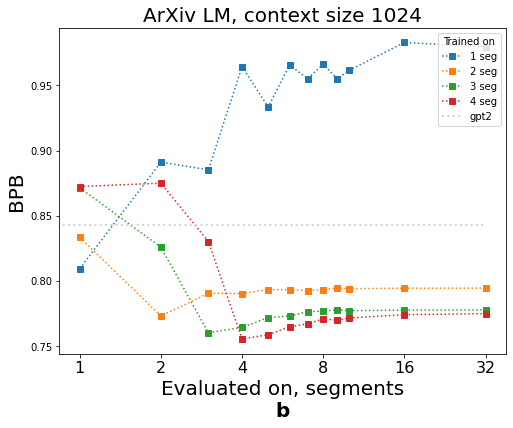

In [24]:
# custom_palette = sns.color_palette("rocket_r", n_colors=table.shape[0])
# sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


baseline_loss = 1.654

tab = table.apply(bpb)[table.columns[:12]]
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{b}$", fontsize=fs)
plt.ylabel('BPB', fontsize=fs)
xt = 2 ** np.arange(6)
# plt.xticks(eval_segments, labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('ArXiv LM, context size 1024', fontsize=fs)

plt.xscale('log', base=2)
plt.xticks(xt, labels=xt, fontsize=fs*0.8)
# plt.ylim(-15, 15)
plt.hlines(bpb(baseline_loss), 0, max(xt), color='lightgrey', linestyle='dotted', lw=2)
models = [f'{i} seg' for i in list(tab.index)] + ['gpt2']
plt.legend(models, title='Trained on', loc='upper right')
plt.savefig('img/extrapolate_lm_1024_abs.pdf', format='pdf', bbox_inches='tight')
plt.show()

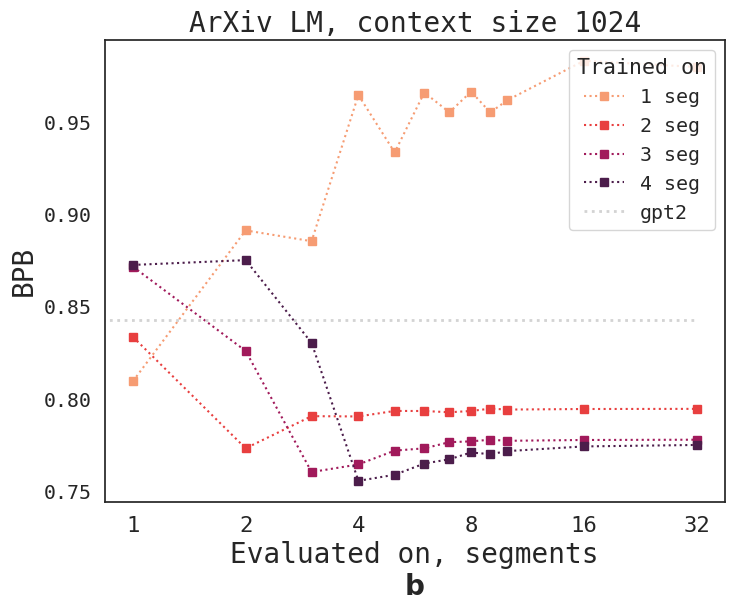

In [ ]:
custom_palette = sns.color_palette("rocket_r", n_colors=table.shape[0])
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


baseline_loss = 1.654

tab = table.apply(bpb)[table.columns[:12]]
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{b}$", fontsize=fs)
plt.ylabel('BPB', fontsize=fs)
xt = 2 ** np.arange(6)
# plt.xticks(eval_segments, labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('ArXiv LM, context size 1024', fontsize=fs)

plt.xscale('log', base=2)
plt.xticks(xt, labels=xt, fontsize=fs*0.8)
# plt.ylim(-15, 15)
plt.hlines(bpb(baseline_loss), 0, max(xt), color='lightgrey', linestyle='dotted', lw=2)
models = [f'{i} seg' for i in list(tab.index)] + ['gpt2']
plt.legend(models, title='Trained on', loc='upper right')
plt.savefig('img/extrapolate_lm_1024_abs.pdf', format='pdf', bbox_inches='tight')
plt.show()

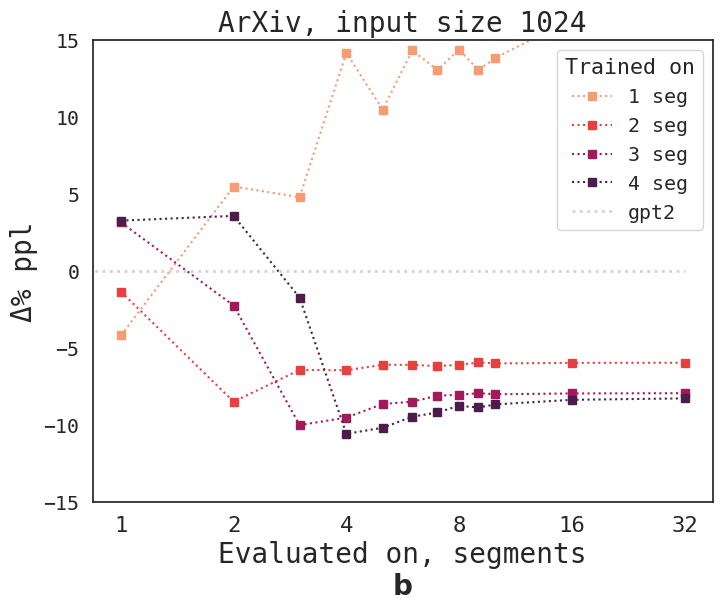

In [366]:
custom_palette = sns.color_palette("rocket_r", n_colors=table.shape[0])
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


baseline_score = 1.658
tab = (table - baseline_score) / baseline_score * 100
tab = tab[tab.columns[:12]]
# tab = table
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{b}$", fontsize=fs)
plt.ylabel('Δ% ppl', fontsize=fs)
xt = 2 ** np.arange(6)
# plt.xticks(eval_segments, labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('ArXiv LM, input size 1024', fontsize=fs)

plt.xscale('log', base=2)
plt.xticks(xt, labels=xt, fontsize=fs*0.8)
plt.ylim(-15, 15)
plt.hlines(0, 0, max(xt), color='lightgrey', linestyle='dotted', lw=2)
models = [f'{i} seg' for i in list(tab.index)] + ['gpt2']
plt.legend(models, title='Trained on', loc='upper right')
plt.savefig('img/extrapolate_lm_1024.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 128

In [27]:
# table.apply(bpb)

### curriculum v2

In [41]:
df = res_df_cv2[res_df_cv2.model_path.apply(lambda x: 'eval' in x)].copy()
df = df[(df.num_mem_tokens == 2) & (df.input_size == 128)]

gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

baseline_score = 2.124
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
# table - baseline_score
# table

In [49]:
# group_df

In [45]:
table

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                         2.197939  2.243968  2.233274  2.271345  2.226228   
2                         2.153939  1.989869  2.086477  2.122600  2.146589   
3                         2.129193  1.937386  1.926049  1.923746  1.923173   
4                         2.113312  1.904956  1.889895  1.886186  1.885043   
5                         2.104219  1.884910  1.867574  1.862870  1.861203   

                                                                      \
eval_segment              6         7         8         9         10   
checkpoint_segment                                                     
1                   2.268547  2.223216  2.265285  2.224020  2.267173   
2                   2.129932  2.147144  2.130463  2.147018  2.130715   
3                   1.923120  1.923159  1.923261  1.923410  1.923567   
4                   1.884716  1.884572  1.884526  1.884532  1.884546   
5                   1.860649  1.860377  1.860258  1.860226  1.860214   

                                                                      \
eval_segment              11        12        13        14        15   
checkpoint_segment                                                     
1                   2.224540  2.267325  2.225166  2.266898  2.225119   
2                   2.243369  2.232969  2.242801  2.233473  2.242311   
3                   1.923735  1.923826  1.923918  1.924005  1.924065   
4                   1.884560  1.884567  1.884571  1.884573  1.884574   
5                   1.860216  1.860216  1.860215  1.860219  1.860221   

                                                  
eval_segment              16        32        64  
checkpoint_segment                                
1                   2.266801  2.264197       NaN  
2                   2.233945  2.235961  2.237646  
3                   1.924121  1.924838  1.924943  
4                   1.884571  1.884563  1.907130  
5                   1.860219  1.860221       NaN

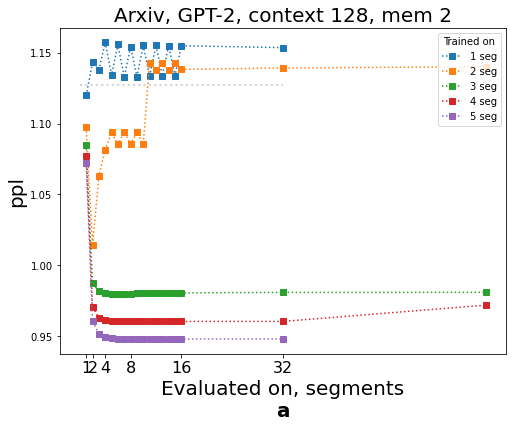

In [46]:
# custom_palette = sns.color_palette("rocket_r", n_colors=table.shape[0])
# sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))

baseline_score = 2.213

tab = table.apply(bpb)
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{a}$", fontsize=fs)
plt.ylabel('ppl', fontsize=fs)
xt = 2 ** np.arange(6)
plt.title('Arxiv, GPT-2, context 128, mem 2', fontsize=fs)


plt.xticks(xt, labels=xt, fontsize=fs*0.8)
plt.hlines(bpb(baseline_score), 0, max(xt), color='lightgrey', linestyle='dotted', lw=2)

models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on', loc='upper right')
# plt.savefig('img/extrapolate_lm_128_abs.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [47]:
np.__version__

'1.21.5'

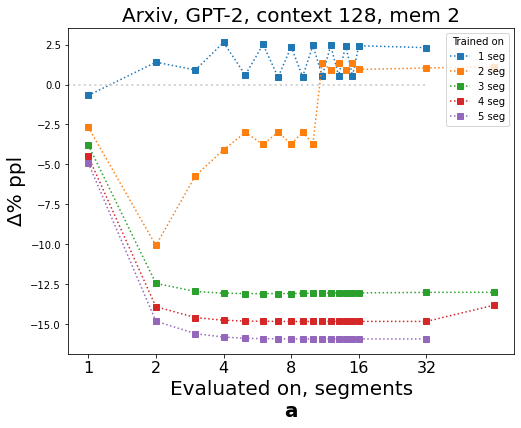

In [48]:
# custom_palette = sns.color_palette("rocket_r", n_colors=table.shape[0])
# sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))

baseline_score = 2.213
tab = (table - baseline_score) / baseline_score * 100
# tab = table
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{a}$", fontsize=fs)
plt.ylabel('Δ% ppl', fontsize=fs)
xt = 2 ** np.arange(6)
# plt.xticks(eval_segments, labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('Arxiv, GPT-2, context 128, mem 2', fontsize=fs)

plt.xscale('log', base=2)
plt.xticks(xt, labels=xt, fontsize=fs*0.8)
plt.hlines(0, 0, max(xt), color='lightgrey', linestyle='dotted', lw=2)
models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on', loc='upper right')
# plt.savefig('img/extrapolate_lm_128.pdf', format='pdf', bbox_inches='tight')
plt.show()

### old curriculum

In [113]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x)].copy()
df = df[(df.num_mem_tokens == 2) & (df.input_size == 128)]

gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

baseline_score = 2.124
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
# table - baseline_score
# table

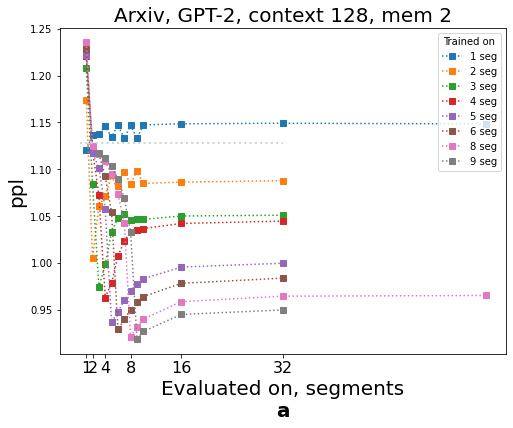

In [94]:
# custom_palette = sns.color_palette("rocket_r", n_colors=table.shape[0])
# sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))

baseline_score = 2.213

tab = table.apply(bpb)
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{a}$", fontsize=fs)
plt.ylabel('ppl', fontsize=fs)
xt = 2 ** np.arange(6)
plt.title('Arxiv, GPT-2, context 128, mem 2', fontsize=fs)


plt.xticks(xt, labels=xt, fontsize=fs*0.8)
plt.hlines(bpb(baseline_score), 0, max(xt), color='lightgrey', linestyle='dotted', lw=2)

models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on', loc='upper right')
plt.savefig('img/extrapolate_lm_128_abs.pdf', format='pdf', bbox_inches='tight')
plt.show()

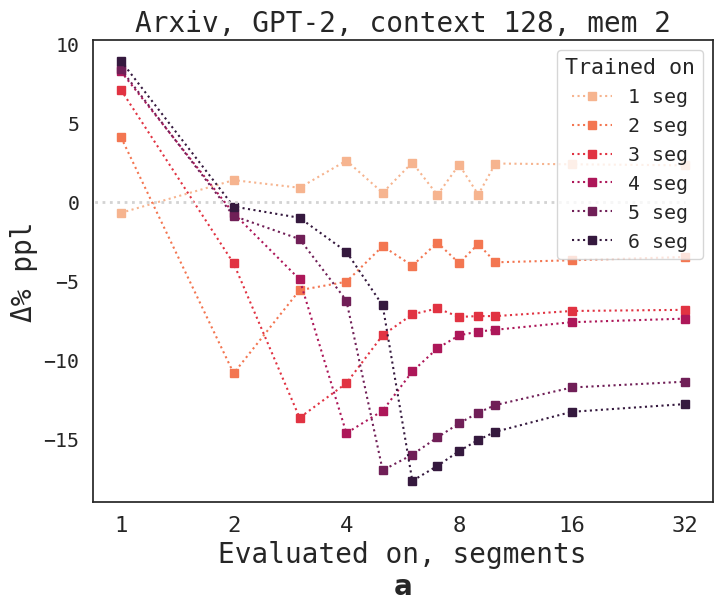

In [375]:
custom_palette = sns.color_palette("rocket_r", n_colors=table.shape[0])
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))

baseline_score = 2.213
tab = (table - baseline_score) / baseline_score * 100
# tab = table
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{a}$", fontsize=fs)
plt.ylabel('Δ% ppl', fontsize=fs)
xt = 2 ** np.arange(6)
# plt.xticks(eval_segments, labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('Arxiv, GPT-2, context 128, mem 2', fontsize=fs)

plt.xscale('log', base=2)
plt.xticks(xt, labels=xt, fontsize=fs*0.8)
plt.hlines(0, 0, max(xt), color='lightgrey', linestyle='dotted', lw=2)
models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on', loc='upper right')
plt.savefig('img/extrapolate_lm_128.pdf', format='pdf', bbox_inches='tight')
plt.show()

### TXL

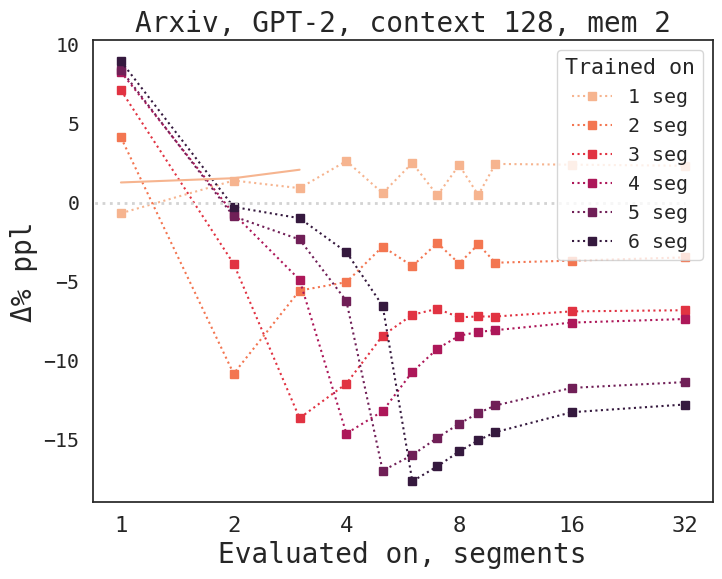

In [348]:
custom_palette = sns.color_palette("rocket_r", n_colors=table.shape[0])
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))

baseline_score = 2.213
tab = (table - baseline_score) / baseline_score * 100
# tab = table
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments', fontsize=fs)
plt.ylabel('Δ% ppl', fontsize=fs)
xt = 2 ** np.arange(6)
# plt.xticks(eval_segments, labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('Arxiv, GPT-2, context 128, mem 2', fontsize=fs)

plt.xscale('log', base=2)
plt.xticks(xt, labels=xt, fontsize=fs*0.8)
plt.hlines(0, 0, max(xt), color='lightgrey', linestyle='dotted', lw=2)


# TXL

txl_df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'xl64' in x)].copy()
plt.plot(txl_df.eval_segment, txl_df.best_valid_loss.apply(bpb))


models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on', loc='upper right')
# plt.savefig('img/extrapolate_lm_128.pdf', format='pdf', bbox_inches='tight')
plt.show()

### eval on seg x 2

In [82]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x)].copy()
df = df[(df.num_mem_tokens == 2) & (df.input_size == 256)]

gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

baseline_score = 2.213
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score
# table

/tmp/ipykernel_21960/3355522368.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_df['std'] = df.groupby(gb_cols).std()[metric_cols]


best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                         0.033262  0.116536  0.078259  0.142493  0.079319   
2                         0.179402  0.016191  0.066806  0.077317  0.087234   
3                         0.339096  0.135970  0.110632  0.149186  0.160108   
4                         0.446104  0.198536  0.162992  0.231518  0.253598   

                                                                                
eval_segment              6         7         8         9         10        16  
checkpoint_segment                                                              
1                   0.141320  0.075341  0.140643  0.075595  0.140312  0.139596  
2                   0.078240  0.084609  0.075325  0.084322  0.075692  0.075348  
3                   0.165054  0.164281  0.164056  0.164632  0.164220  0.163510  
4                   0.262234  0.263419  0.266132  0.267462  0.268798  0.269609

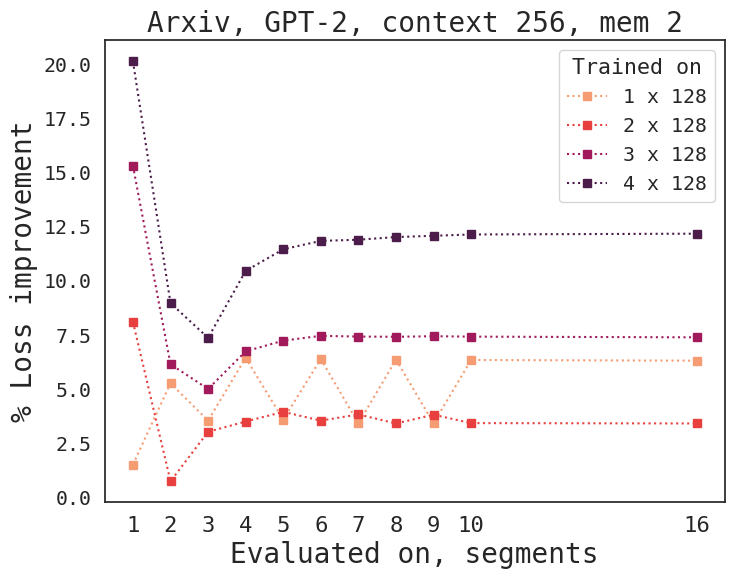

In [83]:
custom_palette = sns.color_palette("rocket_r", n_colors=4)
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


tab = (table - baseline_score) / baseline_score * 100
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]# - baseline_score
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments', fontsize=fs)
plt.ylabel('% Loss improvement', fontsize=fs)
# xt = 2 ** np.arange(3)
xt = eval_segments
plt.xticks(xt, labels=xt, fontsize=fs*0.8)
# plt.xticks(eval_segments, labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('Arxiv, GPT-2, context 256, mem 2', fontsize=fs)

models = [f'{i} x 128' for i in list(tab.index)]
plt.legend(models, title='Trained on')
plt.savefig('img/extrapolate.pdf', format='pdf', bbox_inches='tight')
plt.show()

### wikitext - multiseg

In [443]:
!cd ..;python parse_tb.py

  0%|          | 0/496 [00:00<?, ?it/s]
2023-05-07 20:10:49.843672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-07 20:10:49.843714: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [444]:
res_df = pd.read_csv('../results/wikitext-multiseg.csv')

In [445]:
res_df.num_mem_tokens = res_df.num_mem_tokens.fillna('NA')
res_df.max_n_segments = res_df.max_n_segments.fillna('NA')
# df.share_memory_layers = df.share_memory_layers.fillna(False)
res_df.k2 = res_df.k2.fillna(-1)
res_df['checkpoint_segment'] = res_df.model_path.apply(lambda x: x.split('from_cpt_')[1].split('-')[0] if 'from_cpt_' in x else -1).astype(int)
res_df['eval_segment'] = res_df.max_n_segments
# df['from_cpt'] = (~df.backbone_cpt.isna()).fillna(False)
# df.freeze_model_weights = df.freeze_model_weights.fillna(False)

### extrapolation

In [464]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and ('run_2' in x or 'mem10' in x))].copy()

Text(0, 0.5, 'Valid loss')

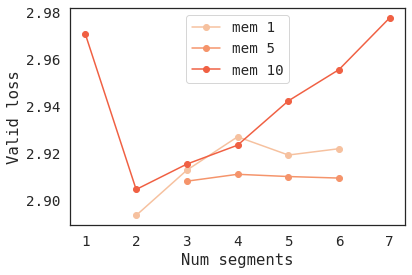

In [465]:
num_tokens = np.unique(df.num_mem_tokens)
for num_mem in num_tokens:
    slc = df[df.num_mem_tokens == num_mem]
    slc = slc[slc.checkpoint_segment == slc.eval_segment].sort_values('checkpoint_segment')
    plt.plot(slc.checkpoint_segment, slc.best_valid_loss, marker='o')
    
plt.legend([f'mem {int(n)}' for n in num_tokens])
plt.xlabel('Num segments')
plt.ylabel('Valid loss')

#### segmented validation mem 5

In [449]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_1' in x)].copy()
df = df[df.num_mem_tokens == 5]

gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                         0.000786  5.240956  6.117512  6.284274  6.347375   
2                         0.092536 -0.056885  0.837013  1.908346  2.579189   
3                         0.114902  0.090783 -0.048290  0.000284  0.219169   
4                         0.160569  0.613973  0.078387 -0.041910  0.012016   
5                         0.183875  4.483671  2.112103  0.031773 -0.022282   
6                         0.183207  6.317534  2.233219  1.076151  0.047572   
7                         0.207037  7.519168  2.898285  3.155314  1.133836   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   6.367681  6.380861  6.386282  6.389956  6.391007  
2                   2.514880  2.503755  2.358686  2.285884  2.195533  
3                   0.753012  1.162861  1.475586  1.666424  1.782091  
4                   0.020721  0.024632  0.033421  0.037747  0.043806  
5                   0.035719  0.048383  0.049893  0.048087  0.047432  
6                  -0.021334  0.041760  0.062554  0.065884  0.066004  
7                   0.061890  0.000708  0.067672  0.089600  0.093359

#### segmented validation mem 10

In [450]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_1' in x)].copy()
df = df[df.num_mem_tokens == 10]

gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score 

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                         0.017031  5.316075  5.761672  5.850764  5.875190   
2                         0.223280 -0.049166  0.690764  1.837431  2.471289   
3                         0.660496  0.256801 -0.038329  0.064743  0.122927   
4                         0.771480  2.727141  0.241103 -0.030258  0.077450   
5                         0.652536  2.571806  2.459379  0.226902 -0.011359   
6                         0.619168  4.395004  4.443750  1.254856  0.189576   
7                         0.526521  4.862644  4.368672  2.254435  1.410561   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   5.885937  5.888419  5.888928  5.890251  5.889996  
2                   2.305344  2.553149  2.479140  2.543201  2.498211  
3                   0.414862  0.835361  1.150606  1.399120  1.564290  
4                   0.109023  0.152481  0.214284  0.286584  0.332159  
5                   0.095366  0.112459  0.134259  0.156879  0.166211  
6                   0.002016  0.092093  0.111999  0.116809  0.092531  
7                   0.170122  0.024124  0.107552  0.197584  0.216722

#### segmented validation run 2

In [377]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_1' in x)].copy()
seg1 = df[df.checkpoint_segment == 1].copy()
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_2' in x)].copy()
df = pd.concat((df, seg1))

In [378]:
# df = pd.concat(df, res_df

In [379]:
gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
# group_df

In [380]:
# table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
# table

In [381]:
baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score 

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                        -0.008798  5.218863  5.758703  5.743047  5.707946   
2                         0.013564 -0.060241  0.020755  1.009615  1.278761   
3                         0.030341 -0.044586 -0.040917 -0.032559  0.088063   
4                         0.027879 -0.013891 -0.027874 -0.026687 -0.027281   
5                         0.031603 -0.032962 -0.032082 -0.034039 -0.034472   
6                         0.036607 -0.031358 -0.028739 -0.030962 -0.031641   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   5.691786  5.687142  5.684877  5.683396  5.682353  
2                   1.259507  1.319373  1.302102  1.322368  1.316135  
3                   0.139166  0.249414  0.329995  0.435976  0.523455  
4                  -0.027712 -0.027730 -0.027750 -0.027742 -0.027751  
5                  -0.034545 -0.034566 -0.034565 -0.034567 -0.034567  
6                  -0.031765 -0.031762 -0.031765 -0.031765 -0.031765

#### segmented validation run 1

In [383]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_1' in x)].copy()


In [384]:
gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
# group_df

In [387]:
# table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
# table

In [386]:
baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score 

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                        -0.008798  5.218863  5.758703  5.743047  5.707946   
2                         0.012470 -0.061500  0.019545  1.009203  1.279158   
3                         0.019572 -0.038069 -0.033884 -0.010757  0.188753   
4                         0.025727 -0.025838 -0.026674 -0.025733 -0.026053   
5                         0.028103 -0.029862 -0.028878 -0.029711 -0.029498   
6                         0.028103 -0.029862 -0.028878 -0.029711 -0.029498   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   5.691786  5.687142  5.684877  5.683396  5.682353  
2                   1.260668  1.318112  1.301867  1.320214  1.313629  
3                   0.334932  0.477607  0.582409  0.685644       NaN  
4                  -0.026302 -0.026357 -0.026370 -0.026373       NaN  
5                  -0.029733 -0.029778 -0.029795       NaN       NaN  
6                  -0.029733 -0.029778 -0.029795       NaN       NaN

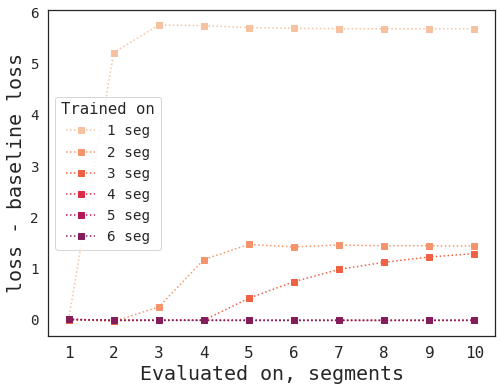

In [350]:
custom_palette = sns.color_palette("rocket_r", n_colors=8)
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


# tab = table[table.columns[:15]].iloc[:7]
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')] - baseline_score
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments', fontsize=fs)
plt.ylabel('loss - baseline loss', fontsize=fs)
plt.xticks(range(1, len(eval_segments)+1), labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
# plt.title('Memorization', fontsize=fs)

models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on')
# plt.savefig('img/extrapolate.pdf', format='pdf', bbox_inches='tight')
plt.show()

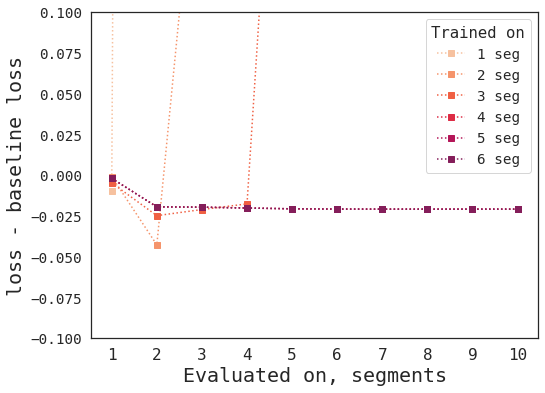

In [351]:
custom_palette = sns.color_palette("rocket_r", n_colors=8)
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


# tab = table[table.columns[:15]].iloc[:7]
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')] - baseline_score
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments', fontsize=fs)
plt.ylabel('loss - baseline loss', fontsize=fs)
plt.xticks(range(1, len(eval_segments)+1), labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
# plt.title('Memorization', fontsize=fs)
plt.ylim(-0.1, 0.1)

models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on')
# plt.savefig('img/extrapolate.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### continuous validation

In [276]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'chunked' in x)].copy()
df['checkpoint_segment'] = df.model_path.apply(lambda x: x.split('from_cpt_')[1].split('-')[0]).astype(int)
df['eval_segment'] = df.max_n_segments

In [277]:
gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
# group_df

In [278]:
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                         2.944067  8.172538  8.713217  8.698071  8.663234   
2                         2.952558  2.910761  3.194788  4.122667  4.418456   
3                         2.948757  2.928664  2.932415  2.935880  3.366055   
4                         2.951539  2.934062  2.933879  2.933349  2.932859   
5                         2.951539  2.934062  2.933879  2.933349  2.932859   
6                         2.951539  2.934062  2.933879  2.933349  2.932859   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   8.646637  8.642073  8.639933  8.638370  8.637287  
2                   4.370034  4.406917  4.391923  4.391372  4.387811  
3                   3.690738  3.929178  4.069761  4.172633  4.238768  
4                   2.932715  2.932674  2.932668  2.932667  2.932667  
5                   2.932715  2.932674  2.932668  2.932667  2.932667  
6                   2.932715  2.932674  2.932668  2.932667  2.932667

In [279]:
baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score 

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                        -0.009393  5.219078  5.759757  5.744611  5.709774   
2                        -0.000902 -0.042699  0.241328  1.169207  1.464996   
3                        -0.004703 -0.024796 -0.021045 -0.017580  0.412595   
4                        -0.001921 -0.019398 -0.019581 -0.020111 -0.020601   
5                        -0.001921 -0.019398 -0.019581 -0.020111 -0.020601   
6                        -0.001921 -0.019398 -0.019581 -0.020111 -0.020601   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   5.693177  5.688613  5.686473  5.684910  5.683827  
2                   1.416574  1.453457  1.438463  1.437912  1.434351  
3                   0.737278  0.975718  1.116301  1.219173  1.285308  
4                  -0.020745 -0.020786 -0.020792 -0.020793 -0.020793  
5                  -0.020745 -0.020786 -0.020792 -0.020793 -0.020793  
6                  -0.020745 -0.020786 -0.020792 -0.020793 -0.020793

<Figure size 576x432 with 0 Axes>

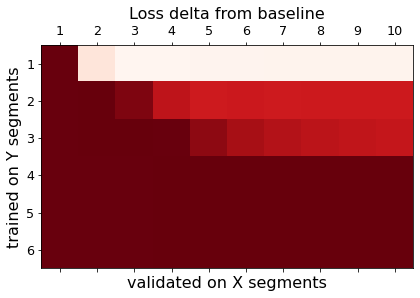

In [280]:
fs = 16
plt.figure(figsize=(8,6))
tab = table[table.columns[:15]].iloc[:7]
plt.matshow((table - baseline_score).values, cmap='Reds_r')
plt.xlabel('validated on X segments', fontsize=fs)
plt.ylabel('trained on Y segments', fontsize=fs)
plt.xticks(range(tab.shape[1]), labels=list(map(lambda x: x[1], tab.columns)), fontsize=fs*0.8)
plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('Loss delta from baseline', fontsize=fs)
# plt.savefig('img/extrapolate_hm.pdf', format='pdf')
plt.show()

### curriculum

In [182]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' not in x and 'from_cpt' in x)].copy()

In [183]:
df['chunked'] = df.model_path.apply(lambda x: 'chunked' in x)

In [184]:
gb_cols = ['input_size', 'max_n_segments', 'chunked', 'num_mem_tokens', 'lr', 'lr_scheduler',]
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_loss  \
input_size max_n_segments chunked num_mem_tokens lr      lr_scheduler                    
128        1              False   1.0            0.00005 linear               2.945818   
           2              False   1.0            0.00005 linear               4.366513   
                          True    1.0            0.00001 linear               4.395957   
           3              False   1.0            0.00005 linear               3.020203   
                          True    1.0            0.00001 linear               4.358905   
           4              False   1.0            0.00005 linear               2.997787   
                          True    1.0            0.00001 linear               2.954910   
           5              False   1.0            0.00005 linear               3.004885   
                          True    1.0            0.00001 linear               2.954769   
           6              False   1.0            0.00005 linear               3.004962   
                          True    1.0            0.00001 linear               2.954784   
           7              False   1.0            0.00005 linear               3.008343   
                          True    1.0            0.00001 linear               2.955649   
           8              False   1.0            0.00005 linear               3.008343   

                                                                            std  \
input_size max_n_segments chunked num_mem_tokens lr      lr_scheduler             
128        1              False   1.0            0.00005 linear        0.000173   
           2              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           3              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           4              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           5              False   1.0            0.00005 linear        0.000000   
                          True    1.0            0.00001 linear             NaN   
           6              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           7              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           8              False   1.0            0.00005 linear             NaN   

                                                                       n_runs  \
input_size max_n_segments chunked num_mem_tokens lr      lr_scheduler           
128        1              False   1.0            0.00005 linear             3   
           2              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           3              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           4              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           5              False   1.0            0.00005 linear             2   
                          True    1.0            0.00001 linear             1   
           6              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           7              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           8              False   1.0            0.00005 linear             1   

    

### vanilla

In [172]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' not in x and 'from_cpt' not in x)]

In [173]:
df = df[df.num_steps > 9000]

In [174]:
gb_cols = ['input_size', 'max_n_segments', 'num_mem_tokens', 'lr', 'lr_scheduler',]
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_loss  \
input_size max_n_segments num_mem_tokens lr      lr_scheduler                    
64         2              1.0            0.00005 linear               5.834481   
                          5.0            0.00005 linear               5.084059   
                          10.0           0.00005 linear               5.978330   
           3              1.0            0.00005 linear               3.196006   
                          5.0            0.00005 linear               3.258076   
                          10.0           0.00005 linear               3.344816   
           4              1.0            0.00005 linear               3.258616   
                          5.0            0.00005 linear               3.224445   
                          10.0           0.00005 linear               3.346584   
           5              1.0            0.00005 linear               3.255840   
                          5.0            0.00005 linear               3.324244   
128        1              1.0            0.00005 linear               2.947527   
                          5.0            0.00005 linear               2.960443   
                          10.0           0.00005 linear               2.976584   
                          NA             0.00005 linear               2.953460   
           2              1.0            0.00005 linear               4.380685   
                          5.0            0.00005 linear               3.526484   
                          10.0           0.00005 linear               4.289703   
           3              1.0            0.00005 linear               3.002402   
                          5.0            0.00005 linear               3.033959   
                          10.0           0.00005 linear               3.075089   
           4              1.0            0.00005 linear               3.016222   
                          5.0            0.00005 linear               3.031811   
                          10.0           0.00005 linear               3.038059   
           5              1.0            0.00005 linear               3.038116   
                          5.0            0.00005 linear               3.080352   
                          10.0           0.00005 linear               3.067651   
           6              1.0            0.00005 linear               3.020492   
256        1              1.0            0.00001 linear               2.825476   
                                         0.00005 linear               2.832754   
                                         0.00008 linear               2.841326   
                          5.0            0.00001 linear               2.833221   
                                         0.00005 linear               2.839976   
                                         0.00008 linear               2.849988   
                          10.0           0.00001 linear               2.839963   
                                         0.00005 linear               2.840628   
                                         0.00008 linear               2.852742   
                          NA             0.00001 linear               2.829825   
                                         0.00005 linear               2.836491   
           2              1.0            0.00001 linear               3.687324   
                                         0.00005 linear               3.688727   
                                         0.00008 linear               3.716200   
                          5.0            0.00001 linear               3.578869   
                                         0.00005 linear               3.601228   
                                         0.00008 linear               3.487755   
                          10.0           0.00001 linear               4.167626   
                                         0.00005 linear               3.826776   
                                         0.00

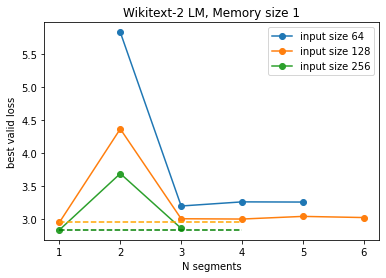

In [104]:
input_sizes = np.unique(df.input_size)
for input_size in input_sizes:
    mask = (df.input_size == input_size) & (df.lr ==0.00005) & (df.num_mem_tokens == 1)
    slc = df[mask]
    
    gb_cols = ['max_n_segments']

    group_df = slc.groupby(gb_cols).min()[metric_cols]
    
    plt.plot(group_df.index, group_df.values, marker='o')
    
plt.hlines(2.953460, 1, 4, linestyle='dashed', color='orange')
plt.hlines(2.836491, 1, 4, linestyle='dashed', color='green')

plt.title('Wikitext-2 LM, Memory size 1')
plt.xlabel('N segments')
plt.ylabel('best valid loss')
plt.legend([f'input size {s}' for s in input_sizes])
plt.xticks(np.unique(df.max_n_segments))
plt.show()

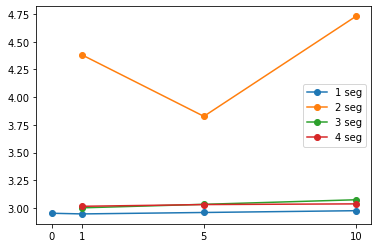

In [74]:
segment_sizes = np.unique(df.max_n_segments)
for n_seg in segment_sizes:
    mask = (df.input_size == 128) & (df.lr ==0.00005) & (df.max_n_segments == n_seg)
    slc = df[mask].copy()
    slc.loc[slc.num_mem_tokens == 'NA', 'num_mem_tokens'] = 0
    
    gb_cols = ['num_mem_tokens']

    group_df = slc.groupby(gb_cols).min()[metric_cols]
    
    plt.plot(group_df.index, group_df.values, marker='o')
    

# plt.title('Wikitext-2 LM, Memory size 1')
# plt.xlabel('N segments')
# plt.ylabel('best valid loss')
plt.legend([f'{s} seg' for s in segment_sizes])
plt.xticks([0, 1, 5, 10])
plt.show()

### wikitext

In [96]:
!cd ..;python parse_tb.py

  0%|          | 0/41 [00:00<?, ?it/s]
2023-04-06 12:34:16.453394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-06 12:34:16.453468: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [88]:
df = pd.read_csv('../results/wikitext.csv')

In [93]:
df.num_mem_tokens = df.num_mem_tokens.fillna('NA')
df.share_memory_layers = df.share_memory_layers.fillna(False)
df.k2 = df.k2.fillna(1)
df['from_cpt'] = (~df.backbone_cpt.isna()).fillna(False)
df.freeze_model_weights = df.freeze_model_weights.fillna(False)

In [94]:
df = df[df.best_valid_loss < 3]

In [95]:
gb_cols = ['from_pretrained', 'model_cls', 'num_mem_tokens', 'lr', 'lr_scheduler', 'k2', 'freeze_model_weights', 'from_cpt']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_loss  \
from_pretrained model_cls                                          num_mem_tokens lr       lr_scheduler         k2   freeze_model_weights from_cpt                    
gpt2            modeling_rmt.language_modeling:RMTDecoderLMHead    10.0           0.000005 linear                1.0 False                False            2.696082   
                                                                   25.0           0.000005 constant_with_warmup  1.0 False                False            2.693921   
                                                                                                                 2.0 False                False            2.693101   
                                                                                           linear                1.0 False                False            2.700119   
                                                                                                                 2.0 False                False            2.697857   
                modeling_rmt.language_modeling:RMTDecoderMemory... 10.0           0.000001 linear                1.0 False                False            2.857818   
                                                                                                                 2.0 False                False            2.839722   
                                                                                  0.000005 linear                1.0 False                False            2.724896   
                                                                                                                 2.0 False                False            2.709527   
                                                                                  0.000010 constant_with_warmup  1.0 True                 True             2.764399   
                                                                                           linear                1.0 False                False            2.698679   
                                                                                                                                          True             2.695399   
                                                                                                                 2.0 False                False            2.684810   
                                                                                  0.000100 constant_with_warmup  1.0 True                 True             2.783597   
                modeling_rmt:RMTDecoderForCausalLM                 10.0           0.000005 constant_with_warmup  1.0 False                False            2.692568   
                                                                                                                 2.0 False                False            2.688242   
                                                                                                                 3.0 False                False            2.688129   
                                                                                  0.000010 constant_with_warmup  1.0 False                False            2.696101   
                                                                                           linear                1.0 False                False            2.707594   
                                                                                  0.000050 constant_with_warmup  1.0 False                False            2.706325   
                                                                                  0.000100 constant_with_warmup  1.0 False                False            2.719023   
                                                                   25.0           0.000010 linear                1.0 False                False            2.833547   
                                                                   50.0           0.000005 constant_with_warmup  1.0 False                Fa

### qmsum

In [348]:
!cd ..;python parse_tb.py

  0%|          | 0/1913 [00:00<?, ?it/s]


In [19]:
# res_df = pd.read_csv('../results/qmsum.csv')

In [ ]:
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
res_df = res_df[res_df.num_steps.isin({3200})]
res_df.fillna('UNKNOWN', inplace=True)

In [ ]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering']
metric_cols = ['best_valid_rouge/geometric_mean']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = res_df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = res_df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

In [37]:
# group_df.sort_values('best_valid_rouge/geometric_mean')

### quality

In [603]:
!cd ..;python parse_tb.py

  0%|          | 0/1630 [00:00<?, ?it/s]


In [45]:
# res_df = pd.read_csv('../results/quality.csv')
paths = [
        '../results/quality.csv',
        '../results/quality_new.csv'
        ]
         

In [46]:
res_df = pd.concat([pd.read_csv(p) for p in paths])
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
# res_df.padding_side = res_df.padding_side.fillna('left')
# res_df = res_df[res_df.num_steps.isin({3200})]
res_df.fillna('UNKNOWN', inplace=True)
res_df = res_df[res_df.num_steps.isin({'UNKNOWN', 3200, 1600})]

In [47]:
# res_df = res_df[res_df.best_valid_exact_match > 1]

In [48]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering' ]
metric_cols = ['best_valid_exact_match']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[['best_valid_exact_match']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['best_valid_exact_match']
group_df['runs'] = res_df.groupby(gb_cols).agg({'best_valid_exact_match':tuple}).best_valid_exact_match.apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_exact_match  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering                           
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                        31.208099   
                               984           25.0           0.00020 linear       True     bidirectional                  21.524450   
                                                                                          regular                         0.000000   
                               998           10.0           0.00005 linear       UNKNOWN  UNKNOWN                        28.395667   
                                                            0.00010 linear       UNKNOWN  UNKNOWN                        30.021550   
                               1002          10.0           0.00020 linear       False    regular                         0.023950   
                                                                                          repeat_first                   28.799150   
                                                                                 True     bidirectional                  28.811151   
                               1024          UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                        32.454498   
                               1503          10.0           0.00020 linear       True     bidirectional                  24.017300   
                                                                                          regular                         0.000000   
                                                                                          repeat_first                   27.468800   

                                                                                                                 std  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering             
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                NaN   
                               984           25.0           0.00020 linear       True     bidirectional     1.559242   
                                                                                          regular           0.000000   
                               998           10.0           0.00005 linear       UNKNOWN  UNKNOWN           0.508137   
                                                            0.00010 linear       UNKNOWN  UNKNOWN           0.167795   
                               1002          10.0           0.00020 linear       False    regular           0.026236   
                                                                                          repeat_first      0.638873   
                                                                                 True     bidirectional     0.813526   
                               1024          UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                NaN   
                               1503          10.0           0.00020 linear       True     bidirectional          NaN   
                                                                                          regular           0.000000   
                                                                                          repeat_first           NaN   

                                                                                                            n_runs  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering           
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                1   
                               984           25.0           0.00020 linear       True     bidirectional          2   
                                                                              